This notebook aims to follow along with Aki Vehtari's [Roaches CV demo](https://users.aalto.fi/~ave/modelselection/roaches.html) but using the `pymc` library and the newest [Arviz](https://arviz-base.readthedocs.io/en/latest/)  
This will not reproduce everything in that demo, but just a few key points:
- Fit a Poisson model to the roaches data
- Fit a negative binomial model to the roaches data
- Fit a Poisson model with varying intercepts for building
- Use various diagnostics to check and compare fits.

SO far my attempt to get it to install is to use my yml but then do a :

```bash
pip install arviz-base
pip install "arviz-stats[xarray]"
pip install "arviz-plots[matplotlib]"
```

TODO: Move these pip installs to the yml file when i figure out how to make it work. (NB> seems to work fine on mac, not on pc yet)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import arviz_base as azb
import arviz_stats as azs
import arviz_plots as azp
#import arviz as az

To get this data, I used rstararm and `data(roaches)` in R and then exported it to a csv file.  

The data consists of :

- `y`: the number of roaches caught.
- `roach1`: pretreatment roach level. (float)
- `senior`: indicates if the apartment is intended for seniors . 
- `exposure2` : the number of trap-days (days  x traps) . 
- `treatment`: indicates if the apartment was treated with a pesticide.  

NOTE: In this[Bambi notebook](https://bambinos.github.io/bambi/notebooks/count_roaches.html) I used this data as an example of using `offset` in Bambi. 

In [27]:
roaches = pd.read_csv("data/roaches.csv")
# rescale 
roaches["sqrt_roach1"] = np.sqrt(roaches["roach1"]) # transform to make less skewed
roaches.head()

,y,roach1,treatment,senior,exposure2,sqrt_roach1
0,153,308.00,1,0,0.800000,17.549929
1,127,331.25,1,0,0.600000,18.200275
2,7,1.67,1,0,1.000000,1.292285
3,7,3.00,1,0,1.000000,1.732051
4,0,2.00,1,0,1.142857,1.414214


## Poisson model

Here we want to fit a Poisson model, `y ~ sqrt_roach1 + treatment +  senior`, to the data with the offset `log(exposure2)`.

In [28]:

mean_sqrt_roach1 = roaches["sqrt_roach1"].mean()

# Set up base_model that can be copied for different likelihoods
with pm.Model() as base_model:
    # Data
    sqrt_roach1_c = pm.Data("sqrt_roach1_c", roaches["sqrt_roach1"]- mean_sqrt_roach1) # center the data
    offset = pm.Data("offset",np.log(roaches["exposure2"])) # see bambi notebook for explanation
    senior = pm.Data("senior", roaches["senior"])  # center the data
    treatment = pm.Data("treatment", roaches["treatment"])
    y_data = pm.Data("y_data", roaches["y"])  

    # Priors
    b_sqrt_roach1 = pm.Normal("b_sqrt_roach1", mu=0, sigma=1)
    b_treatment = pm.Normal("b_treatment", mu=0, sigma=1)
    b_senior = pm.Normal("b_senior", mu=0, sigma=1)  
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    
    
    mu = pm.Deterministic("mu",  intercept + b_sqrt_roach1*sqrt_roach1_c + b_treatment*treatment + b_senior*senior + offset)
    
    count = pm.Deterministic("count", pm.math.exp(mu))

poisson_model = base_model.copy()

with poisson_model:

    # Likelihood
    y= pm.Poisson("y", mu=poisson_model['count'], observed=poisson_model['y_data'])

    # Sample from the posterior
    trace_poisson = pm.sample()
    


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


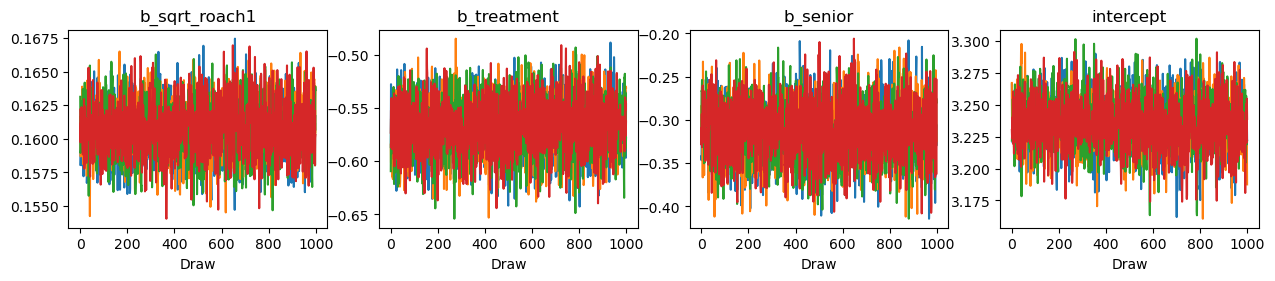

In [29]:

azp.plot_trace(trace_poisson,  var_names=["b_sqrt_roach1", "b_treatment", "b_senior", "intercept"]);

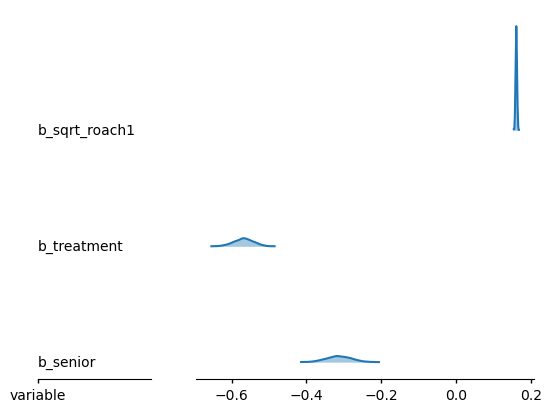

In [30]:
azp.plot_ridge(trace_poisson, var_names=["b_sqrt_roach1", "b_treatment", "b_senior"], combined = True)

We can see right away that this model is not good, the data is overdispersed by looking at the posterior predictive checks.

In [31]:
# borrowed from my other notebook, helper function. 
def plot_log_posterior_ppc(idata):
    # plot posterior predictive check
    var_name = 'log(y+1)'
    # there is probably a better way
    idata.posterior_predictive[var_name] = np.log(idata.posterior_predictive['y'] + 1)
    idata.observed_data[var_name] = np.log(idata.observed_data['y'] + 1)
    
    return azp.plot_ppc_dist(idata, var_names = var_name)


Sampling: [y]


Output()

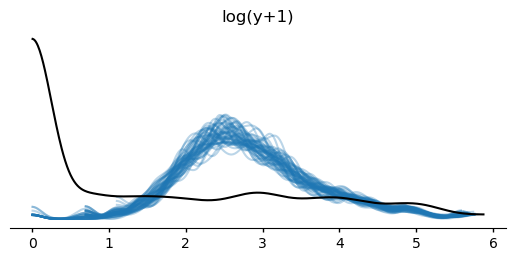

In [32]:
with poisson_model:
   pp_poisson =  pm.sample_posterior_predictive(trace_poisson) # note, i dont use extend_inference here as it messes up loo-pit

plot_log_posterior_ppc(pp_poisson)

We can also plot instead the ecdf.

/var/folders/ky/7fzpzfg13g9ggl74h1z_2kkr0000gn/T/ipykernel_35887/2911090072.py:1: UserWarning: Detected at least one discrete variable.
Consider using plot_ppc variants specific for discrete data, such as plot_ppc_pava or plot_ppc_rootogram.
  azp.plot_ppc_dist(pp_poisson, var_names = "y",kind = "ecdf")


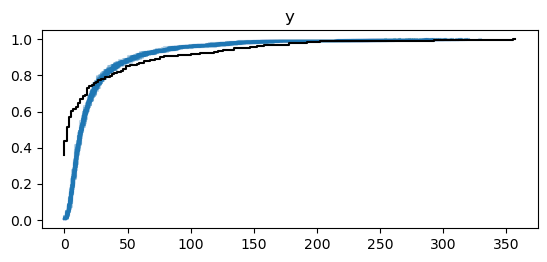

In [33]:
azp.plot_ppc_dist(pp_poisson, var_names = "y",kind = "ecdf")

Ok, lets add the log likelihood so we can do psis-loo:

In [34]:
# add log likelihood
with poisson_model:
    pm.compute_log_likelihood(trace_poisson, extend_inferencedata=True)

Output()

In [35]:
loo_poisson = azs.loo(trace_poisson)
loo_poisson

/Users/ronaldlegere/miniconda3/envs/pymc_bda3/lib/python3.13/site-packages/arviz_stats/loo/helper_loo.py:857: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 262 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5460.91   693.88
p_loo      254.94        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      246   93.9%
   (0.70, 1]   (bad)         8    3.1%
    (1, Inf)   (very bad)    8    3.1%

We see some points hae high Pareto k values

R has a nice method for `plot` that will just plot the pareto_k values. In arviz this is called `plot_khat`.
In the new arviz-plots I cannnot find an equivalent.  However it is simple enough to plot it ourselves:

<Axes: >

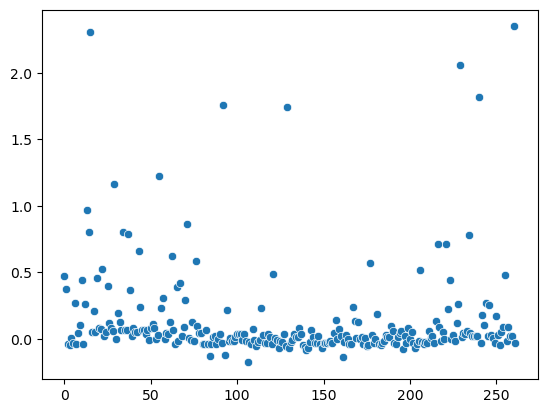

In [36]:
sns.scatterplot(loo_poisson.pareto_k)

There are several observation with high Pareto k values, and so these are very influential to the loo calculation, and also indicate model mis-specification.

Sampling: [y]


Output()

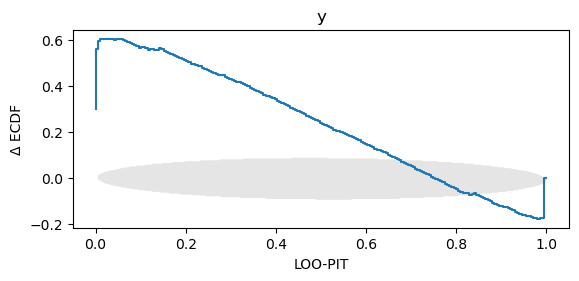

In [37]:
with poisson_model:
    pm.sample_posterior_predictive(trace_poisson, extend_inferencedata=True)
azp.plot_loo_pit(trace_poisson)

This shows the probability integral transform (PIT)  (https://arviz-devs.github.io/EABM/Chapters/Prior_posterior_predictive_checks.html#pit-ecdfs)

Ideally if the model is good, the PIT values should be uniform(0,1) distributed.   Here we see a large departure from uniformity, indicating again that the model is not good.

Now that we know we will want log likelihoods, we can pass in `idata_kwargs={"log_likelihood": True}` to the `sample` method in the future. Lets go ahead and move on to the negative binomial model.

## Negative Binomial model

In [38]:
nbinom_model = base_model.copy()
with nbinom_model:
    # Priors
    alpha = pm.Gamma("alpha", mu=1, sigma=3)  # shape parameter for negative binomial

    # Likelihood
    y = pm.NegativeBinomial("y", mu=nbinom_model["count"], alpha = alpha, observed=nbinom_model['y_data'])

    # Sample from the posterior
    trace_nbinom = pm.sample(idata_kwargs = {"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_sqrt_roach1, b_treatment, b_senior, intercept, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [y]


Output()

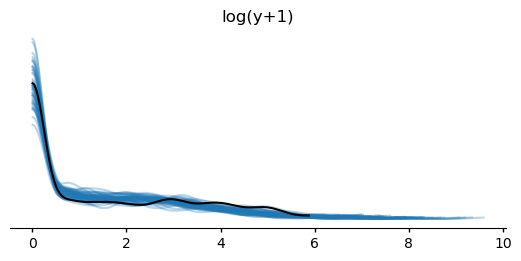

In [39]:
with nbinom_model:
  pp_nbinom =   pm.sample_posterior_predictive(trace_nbinom)

plot_log_posterior_ppc(pp_nbinom)

Posterior predictive check is MUCH better.

Sampling: [y]


Output()

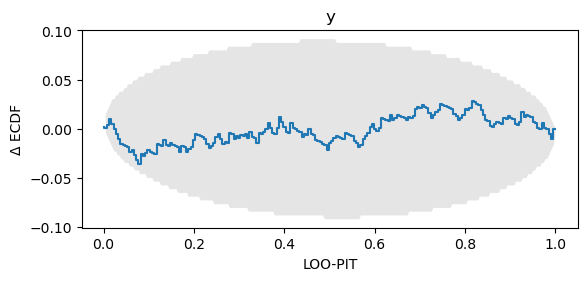

In [40]:
with nbinom_model: 
    pm.sample_posterior_predictive(trace_nbinom, extend_inferencedata=True)

azp.plot_loo_pit(trace_nbinom) 

Loo-pit is consistent with uniform(0,1) distribution, so this model is much better.

/Users/ronaldlegere/miniconda3/envs/pymc_bda3/lib/python3.13/site-packages/arviz_stats/loo/helper_loo.py:857: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: >

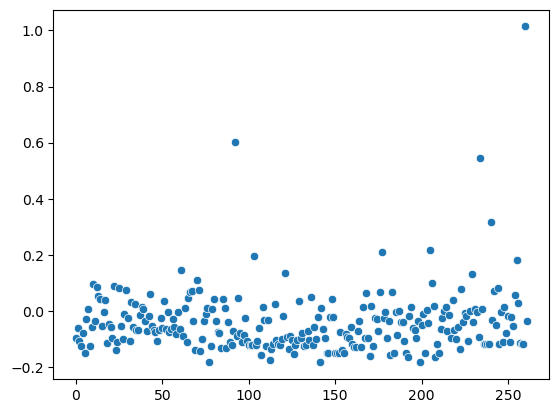

In [41]:
loo_nb = azs.loo(trace_nbinom)
sns.scatterplot(loo_nb.pareto_k)

Only a few outliers, and none are > 1. 

In [93]:
loo_nb

Computed from 4000 posterior samples and 262 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -882.02    38.39
p_loo        8.31        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      261   99.6%
   (0.70, 1]   (bad)         1    0.4%
    (1, Inf)   (very bad)    0    0.0%

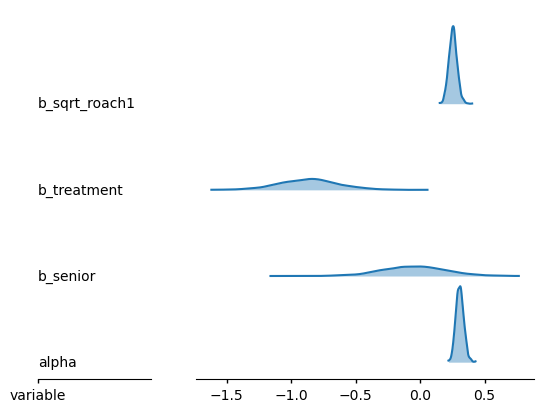

In [17]:
azp.plot_ridge(trace_nbinom,
               var_names=["b_sqrt_roach1", "b_treatment", "b_senior","alpha"])

Note that the treatment effect is much smaller, and that the senior effect is not overlapping with zero. I also plot alpha so that we can see that overdispersion is significant.

## Poisson model with varying intercepts

The overdispersion might be due to unmeasured heterogeneity between buildings. We can add a varying intercept for building to try this. Vehtari's example tells us to expect trouble. 




In [4]:
roaches = roaches.reset_index() # add index as a column for building id
roaches.rename(columns={"index":"id"}, inplace=True)

In [5]:
import pymc as pm
import numpy as np
import pandas as pd

# we define a function so we can later use it in k-fold cross validation

def fit_varying_intercept_model(roaches_data):
    n_ids = roaches_data["id"].nunique()
    id_idx = roaches_data["id"].values
    with pm.Model() as model:
        # Data
        sqrt_roach1_c = pm.Data("sqrt_roach1_c", roaches_data["sqrt_roach1"] - roaches_data["sqrt_roach1"].mean())
        offset = pm.Data("offset", np.log(roaches_data["exposure2"]))
        senior = pm.Data("senior", roaches_data["senior"])
        treatment = pm.Data("treatment", roaches_data["treatment"])
        y_data = pm.Data("y_data", roaches_data["y"])
        id_data = pm.Data("id", id_idx)

        # Hyperprior for varying intercepts
        sigma_a = pm.HalfNormal("sigma_a", sigma=1.0)

        # Group-level intercepts (non-centered parameterization)
        z = pm.Normal("z", mu=0, sigma=1, shape=n_ids)
        a_id = pm.Deterministic("a_id", z * sigma_a)

        # Fixed effects
        b_sqrt_roach1 = pm.Normal("b_sqrt_roach1", mu=0, sigma=1)
        b_treatment = pm.Normal("b_treatment", mu=0, sigma=1)
        b_senior = pm.Normal("b_senior", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)

        # Linear predictor
        mu = intercept + a_id[id_data] + b_sqrt_roach1 * sqrt_roach1_c + b_treatment * treatment + b_senior * senior + offset
        mu_exp = pm.Deterministic("mu", pm.math.exp(mu))

       
        y = pm.Poisson("y", mu=mu_exp, observed=y_data)

        trace = pm.sample(idata_kwargs={"log_likelihood": True}, tune=2000, target_accept=0.97)
    return model, trace

varying_intercept_model, trace_vi = fit_varying_intercept_model(roaches)
 


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
azs.summary(trace_vi, var_names=["b_sqrt_roach1", "b_treatment", "b_senior", "intercept", "sigma_a"])

summary,mean,sd,eti94_lb,eti94_ub,ess_bulk,ess_tail,r_hat,mcse_mean,mcse_sd
label,,,,,,,,,
b_sqrt_roach1,0.33,0.03,0.28,0.39,196.41,454.12,1.01,0.00,0.00
b_treatment,-0.78,0.26,-1.26,-0.30,146.59,456.55,1.02,0.02,0.01
b_senior,-0.74,0.30,-1.31,-0.20,218.04,360.00,1.03,0.02,0.01
intercept,1.67,0.22,1.22,2.07,189.10,293.65,1.02,0.02,0.01
sigma_a,2.02,0.13,1.79,2.27,279.35,752.39,1.02,0.01,0.01


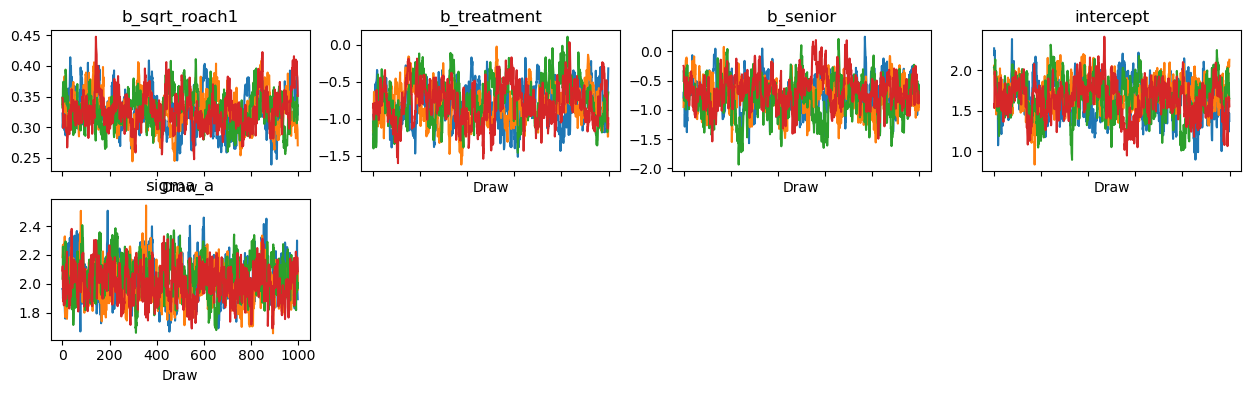

In [7]:
azp.plot_trace(trace_vi,  var_names=["b_sqrt_roach1", "b_treatment", "b_senior", "intercept", "sigma_a"]);

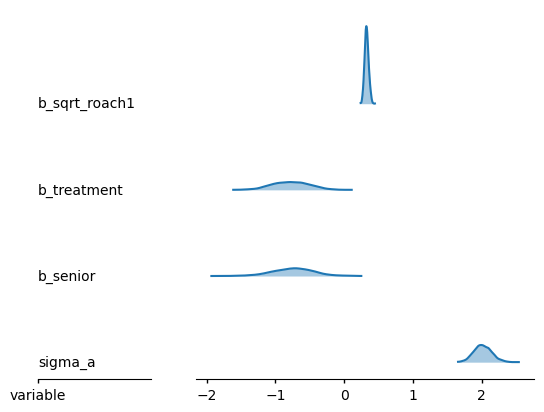

In [8]:
azp.plot_ridge(trace_vi,
               var_names=["b_sqrt_roach1", "b_treatment", "b_senior","sigma_a"])

Note that the parameters are simular except that the b_senior is not consistent with zero anymore.

Sampling: [y]


Output()

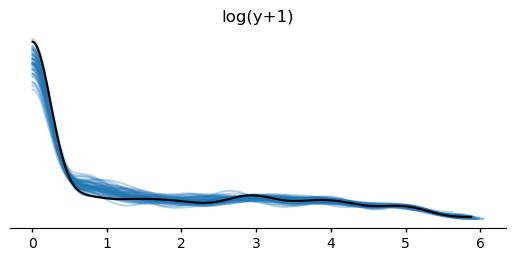

In [11]:
with varying_intercept_model:
   pp_vi =  pm.sample_posterior_predictive(trace_vi) # note, i dont use extend_inference here as it messes up loo-pit

plot_log_posterior_ppc(pp_vi)

The trouble comes when we try to use psis-loo:

/Users/ronaldlegere/miniconda3/envs/pymc_bda3/lib/python3.13/site-packages/arviz_stats/loo/helper_loo.py:857: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: >

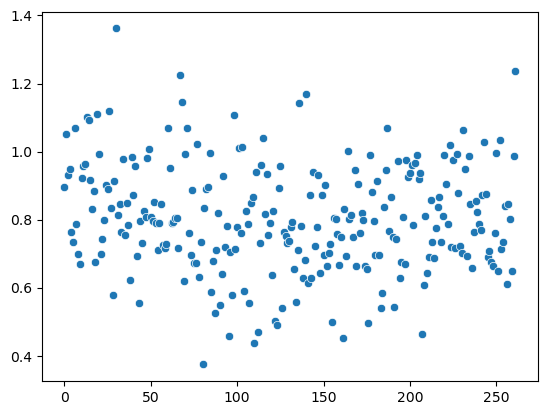

In [12]:
loo_vi = azs.loo(trace_vi)
sns.scatterplot(loo_vi.pareto_k)

The high pareto k values are due to the very flexible model.  However we can instead use k-fold cross validation.  As far as I know there is no easy way to do this in pymc/arviz, we will have to do it manually.

In [52]:
roaches

,level_0,id,y,roach1,treatment,senior,exposure2,sqrt_roach1
0,0,0,153,308.00,1,0,0.800000,17.549929
1,1,1,127,331.25,1,0,0.600000,18.200275
2,2,2,7,1.67,1,0,1.000000,1.292285
3,3,3,7,3.00,1,0,1.000000,1.732051
4,4,4,0,2.00,1,0,1.142857,1.414214
...,...,...,...,...,...,...,...,...
257,257,257,0,0.00,0,1,1.485714,0.000000
258,258,258,0,0.00,0,1,1.000000,0.000000
259,259,259,0,0.00,0,1,1.000000,0.000000
260,260,260,171,0.00,0,1,1.000000,0.000000


In [14]:
from sklearn.model_selection import KFold

# Number of folds
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)

folds = []

for train_index, test_index in kf.split(roaches):
    train_df = roaches.iloc[train_index].reset_index(drop=True)
    test_df = roaches.iloc[test_index].reset_index(drop=True)
    train_df["id"] = np.arange(len(train_df)) # reset id for training set
    folds.append((train_df, test_df))


In [15]:
(train,test ) = folds[1] # for testing

In [16]:
train_model, train_trace = fit_varying_intercept_model(train)
train_trace

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [17]:
samples =   azb.extract(train_trace, group = "posterior", combined= True,
                   var_names = ["b_sqrt_roach1", "b_treatment", "b_senior", "intercept", "sigma_a"]).to_dataframe()

In [18]:
len(samples)

4000

In [20]:
from scipy.special import logsumexp

def compute_elpd_from_matrix(log_lik_matrix):
    # log_lik_matrix: (n_samples, n_test)
    # pointwise ELPD_j = log [ mean_s p(y_j | θ_s) ]
    lppd_j = logsumexp(log_lik_matrix, axis=0) - np.log(log_lik_matrix.shape[0])
    return lppd_j.sum()


In [ ]:
from scipy.stats import poisson


def compute_log_lik(samples, train, test):
    """
    Compute the log-likelihood of the test data given the posterior samples from the training data.
    
    Parameters:
    samples (DataFrame): Posterior samples from the training data.
    train (DataFrame): Training dataset. (needed for centering)
    test (DataFrame): Test dataset.
    
    Returns:
    sum of mean log likelihood over the test points.
    """
    n_samples = len(samples)
    n_test = len(test)
    
    log_lik_matrix = np.zeros((n_samples, n_test))
    
    # Test inputs (centered using training mean)
    sqrt_roach1_c = test["sqrt_roach1"] - train["sqrt_roach1"].mean()
    treatment = test["treatment"].values
    senior = test["senior"].values
    offset = np.log(test["exposure2"])
    y_obs = test["y"].values
    
    for i in range(n_samples):
        # Draw a new group-level intercept for each test point
        a_new = np.random.normal(0, samples["sigma_a"].iloc[i], size=n_test)
        #a_new = np.random.normal(0, 2, size=n_test)
        #a_new = 0.0
        
        mu_i = (
            samples["intercept"].iloc[i]
            + samples["b_sqrt_roach1"].iloc[i] * sqrt_roach1_c.values
            + samples["b_treatment"].iloc[i] * treatment
            + samples["b_senior"].iloc[i] * senior
            + a_new
            + offset
        )
        
        lambda_i = np.exp(mu_i)
        log_lik_matrix[i, :] = poisson.logpmf(y_obs, mu=lambda_i)
        #print(log_lik_matrix.shape)
    
    return compute_elpd_from_matrix(log_lik_matrix)

compute_log_lik(samples, train, test) 

np.float64(-81.0964278612054)

In [22]:
eplds = []
for (train, test) in folds:
    train_model, train_trace = fit_varying_intercept_model(train)
    samples = azb.extract(train_trace, group="posterior", combined=True,
                          var_names=["b_sqrt_roach1", "b_treatment", "b_senior", "intercept", "sigma_a"]).to_dataframe()
    log_lik = compute_log_lik(samples, train, test)
    eplds.append(log_lik)
    print(f"Log-likelihood for fold: {log_lik}")

print(f"ELPD for all folds: {sum(eplds)}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -105.08851153650323


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Log-likelihood for fold: -81.46586774034745


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -92.62636204114482


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -71.81218426479919


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -87.21590312054748


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -73.89570740645159


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -86.58737729281053


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -109.32548539012801


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...


Log-likelihood for fold: -84.24147747101844


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, b_sqrt_roach1, b_treatment, b_senior, intercept]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Log-likelihood for fold: -88.51714536316364
ELPD for all folds: -880.7760216269144


In [44]:
loo_nb

Computed from 4000 posterior samples and 262 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -882.07    38.45
p_loo        8.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      261   99.6%
   (0.70, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    1    0.4%

In [25]:
eplds

[np.float64(-105.08851153650323),
 np.float64(-81.46586774034745),
 np.float64(-92.62636204114482),
 np.float64(-71.81218426479919),
 np.float64(-87.21590312054748),
 np.float64(-73.89570740645159),
 np.float64(-86.58737729281053),
 np.float64(-109.32548539012801),
 np.float64(-84.24147747101844),
 np.float64(-88.51714536316364)]

In [43]:
np.sum(eplds),np.sqrt(10)*np.std(eplds)

(np.float64(-880.7760216269144), np.float64(35.9000296994526))

Not very different. And there are some differneces due to fitting less data in the 10-fold case.